In [1]:
import numpy as np
from neural_network_dynamics import main as ntwk
from datavyz import nrnvyz
from datavyz import ge
from model import Model
%matplotlib inline
# np.savez('study.npz', **Model)

INFO       Cache size for target "cython": 1066 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "/home/yann/.cython/brian_extensions" directory. [brian2]


# Mechanism detail

In [3]:
cd /home/yann/work/zinc-NMDA-modulation/

/home/yann/work/zinc-NMDA-modulation


In [4]:
from scipy.special import erf
from model import Model

def inactivation_function(c, c0=0., dc=1.):
    """
    inactivation function derived from error function
    """
    return (erf((c-c0)/dc)+1.)/2.

def double_exponential(t, T1, T2):
    """
    double exponential function normalized to peak level
    """
    return (np.exp(-t/T2)-np.exp(-t/T1))/(T2/T1-1)*((T2/T1)**(T2/(T2-T1)))


def compute_time_variations_from_events(SET_OF_EVENTS, t,
                                        Trise=.1e-3, Tdecay=10e-3, quantal=1.):
    """
    integration of synaptic events to shape the synaptic conductance
    (convolution with double exponential over synaptic events)
    """
    conductance = 0*t # initialized to 0

    dt = t[1]-t[0]
    
    ilength = int(5*(Tdecay+Trise)/dt) # for each even we 
    event_waveform = quantal*double_exponential(t[:ilength]-t[0], Trise, Tdecay)
    
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event)**2) # find the time point where the event falls
        conductance[i0:min([i0+ilength,len(t)])] += event_waveform[:min([ilength,len(t)-i0])]
        
    return conductance


def compute_pre_from_events(SET_OF_EVENTS, t, delay=0):
    conductance = 0*t # initialized to 0
    for event in SET_OF_EVENTS:
        i0 = np.argmin((t-event-delay)**2) # find the time point where the event falls
        conductance[i0] = 1
    return conductance

def sigmoid(x, x0=0.5, dx=0.1):
    return 1./(np.exp(-(x-x0)/dx)+1)

def sigmoid_deriv(x, dx=0.1):
    return np.exp(-(x-.5)/dx)/dx/(np.exp(-(x-.5)/dx)+1)**2

def voltage_dep_NMDA(x):
    return 1./(0.3+np.exp(-1e3*x*0.08))

def binding_increment(b, b0=1):
    return b0*(1-b)

def solve_synapse_equation(t, Model,
                           Glut_events=[],
                           alpha_Zn=0.4,
                           Vm=None):
         
    dt = t[1]-t[0]
    pre_events = compute_pre_from_events(Glut_events, t)
    sim = {'t':t, 'mZn':[],
           'Glut_event_trace':pre_events}

    # Ib
    xZn, bZn = 0*t, 0*t
    for i in range(len(t)-1):
        xZn[i+1] = xZn[i]-dt/1e-3/Model['tauDecayZn']*xZn[i]
        #bZn[i+1] = bZn[i]+dt/1e-3/Model['tauRiseZn']*(sigmoid(xZn[i],
        #                                    x0=Model['x0'], dx=Model['deltax'])-bZn[i])
        # bZn[i+1] = bZn[i]+dt/1e-3/Model['tauRiseZn']*(xZn[i]-bZn[i])
        
        if pre_events[i+1]>0:
            bZn[i+1:] = xZn[i]
            sim['mZn'].append(xZn[i])
            xZn[i+1] += binding_increment(xZn[i+1], b0=Model['Deltax0'])
            #xZn[i+1] += sigmoid_deriv(xZn[i+1], dx=Model['deltax'])*Model['dx_Zn']/sigmoid_deriv(0.5, dx=0.1)
           
    sim['bZn'], sim['xZn'] = bZn, xZn
    
    # NMDA before voltage-dependency and Zinc modulation
    gNMDA = compute_time_variations_from_events(Glut_events, t,
                                                Trise=1e-3*Model['tauRiseNMDA'],
                                                Tdecay=1e-3*Model['tauDecayNMDA'],
                                                quantal=1e-9*Model['qNMDA'])
    
    # modulation function:    
    def NMDA_modulation(Vm, bZn):
        return voltage_dep_NMDA(Vm)*(1.-Model['alphaZn']*bZn)
    
    sim['gNMDA'] = NMDA_modulation(Vm,sim['bZn'])*gNMDA

    return sim

In [5]:
import os
from model import Model
from analyz.IO.npz import load_dict
Dx0 = Model['Deltax0'] # storing for the future

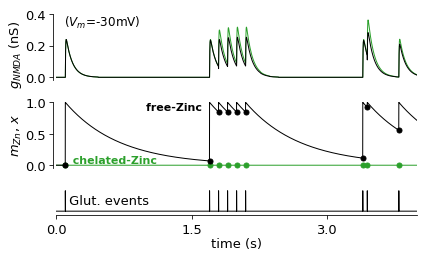

In [8]:
from datavyz import ges as ge
t = np.arange(4000)*1e-3
# same events in voltage-clamp -> hyperpolarized
EVENTS = [0.1]+list(np.arange(5)*0.1+1.7)+[3.4]+[3.45]+[3.8]
Model['Deltax0'] = 0
sim0 = solve_synapse_equation(t, Model, Glut_events=EVENTS, Vm=-30e-3)

Model['Deltax0'] = 1
# then taking the final (=best-fit) model
fit = load_dict(os.path.join('data', 'calib', 'best-freeZn-config.npz'))
for key in fit:
   Model[key] = fit[key]

sim1 = solve_synapse_equation(t, Model, Glut_events=EVENTS, Vm=-30e-3)

fig1, AX = ge.figure(axes_extents=[[[1,2]], [[1,2]], [[1,1]]],
                    figsize=(1.7,.25), hspace=1.5, top=3., bottom=3., left=0.5, right=3.)
# model1
ge.plot(t, sim1['Glut_event_trace'], ax=AX[2],
        axes_args={'spines':['bottom'], 'xlabel':'time (s)', 'xlim':[t[0],t[-1]]})
ge.annotate(AX[2], ' Glut. events', (EVENTS[0], 0.2), xycoords='data')
AX[1].plot(t, 0*t,  lw=1, color=ge.green, label = ' ')
AX[1].plot(EVENTS, np.zeros(len(EVENTS)), 'o', ms=5, color=ge.green, label=' ')
AX[1].plot(t, sim1['xZn'],  lw=1, color='k', label='  $x$')
AX[1].plot(EVENTS, sim1['mZn'], 'o', ms=5, color='k', label='  $m_{Zn}$')
# AX[1].plot(t, sim1['bZn'],  '-', lw=0.5, color='gray', label='x')

ge.set_plot(AX[1], ['left'],
            ylabel='$m_{Zn}$, $x$',
            ylim=[-0.05,1.01], yticks=[0,0.5,1.], xlim=[t[0],t[-1]])

AX[0].plot(t, 1e9*sim0['gNMDA'],  color=ge.green, lw=1, label='chelated-Zinc: $\Delta x^0$=0')
AX[0].plot(t, 1e9*sim1['gNMDA'], color='k', lw=1,
           label='free Zinc: $\Delta x^0$=1, $\\alpha_{Zn}$=%.1f' % (Model['alphaZn']))
           
ge.set_plot(AX[0], ['left'], ylabel = '$g_{NMDA}$ (nS)    ',
            yticks = [0,.2,.4], xlim=[t[0],t[-1]])

#ge.legend(AX[0], loc=(.5,.3), labelspacing=0.2)
ge.annotate(AX[0], '($V_m$=-30mV)', (.02,.75), size='small')
#ge.legend(AX[1], loc=(.09,0.05), labelspacing=-0.1, ncol=2, columnspacing=0, handlelength=.6, color=ge.grey)
ge.annotate(AX[1], '  chelated-Zinc', (EVENTS[0],0.), size='x-small', bold=True, color=ge.green, xycoords='data')
ge.annotate(AX[1], 'free-Zinc  ', (EVENTS[1],1.), size='x-small', bold=True, xycoords='data', va='top', ha='right')

# ax = ge.inset(AX[1], [.88,.6,.13,.5])
# x = np.linspace(0,1)
# ge.annotate(ax, '$\Delta x^0 $', (0.05, .9), color='gray')
# ax.plot(x, Model['Deltax0']*(1-x), '-', lw=1.5, color='gray')
# ax.plot(x, 0*x, color=ge.green, lw=3)
# ge.set_plot(ax, size='small', xticks=[0,1], yticks=[0,1],
#             xlabel='$x$', ylabel='$\Delta x$', xlim=[0,1], ylim=[0,1],
#             tck_outward=0, xlabelpad=-10, ylabelpad=-2, ycolor='grey', xcolor='grey')


Spreading 915 synapses over the segments


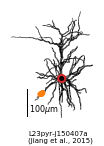

In [6]:
from datavyz import ge
morpho = ntwk.Morphology.from_swc_file(Model['morpho_file_1'])
SEGMENTS = ntwk.morpho_analysis.compute_segments(morpho)
 nseg = len(SEGMENTS['x'])

vis = nrnvyz(SEGMENTS, ge=ge)

synapses_loc = 2450+np.arange(10)

fig2, ax = ge.figure(figsize=(1.2,3.), left=0, right=0., top=0., bottom=0.08)
vis.plot_segments(SEGMENTS['comp_type']!='axon',
                  ax=ax, bar_scale_args=dict(loc=(-130,-140), Ybar=100,
                                  Ybar_label=' 100$\mu$m', orientation='left-top'))

basal_cond = ntwk.morpho_analysis.find_conditions(SEGMENTS,
                                                  comp_type='dend',
                                                  min_distance_to_soma=20e-6)
Nsyn, pre_to_iseg,\
        Nsyn_per_seg = ntwk.spread_synapses_on_morpho(SEGMENTS,
                                                      10, # density
                                                      cond=basal_cond,
                                                      density_factor=1./100./1e-12)
# vis.add_dots(ax, np.random.choice(pre_to_iseg, 70), 5, ge.purple)

vis.add_dots(ax, synapses_loc, np.ones(len(synapses_loc))*30, ge.orange)
vis.add_circle(ax, 0, 50, ge.red, lw=2)

ge.annotate(fig2, 'L23pyr-j150407a\n(Jiang et al., 2015)', (0.27, 0.02), size='small')
#ge.save_on_desktop(fig2)

In [7]:
from single_cell_sim import initialize_sim, EXC_SYNAPSES_EQUATIONS, ON_EXC_EVENT

def run_demo_sim(Model,
                 Vcmd = -30,
                 t0_stim=100.,
                 freq_pulses=20., # Hz
                 n_pulses=5,
                 tstop=500.,
                 synapses_loc = 2450+np.arange(10)):

    Model['VC-cmd'] = Vcmd
    Model['tstop'] = tstop
    
    # initialize voltage-clamp sim
    t, neuron, SEGMENTS = initialize_sim(Model, method='voltage-clamp')

    spike_IDs, spike_times = np.empty(0, dtype=int), np.empty(0, dtype=float)
    for i in range(n_pulses):
        spike_times = np.concatenate([spike_times,
                                      (t0_stim+i*1e3/freq_pulses)*np.ones(len(synapses_loc))])
        spike_IDs = np.concatenate([spike_IDs,np.arange(len(synapses_loc))])
    
    Estim, ES = ntwk.process_and_connect_event_stimulation(neuron,
                                                           spike_IDs, spike_times,
                                                           synapses_loc,
                                                           EXC_SYNAPSES_EQUATIONS.format(**Model),
                                                           ON_EXC_EVENT.format(**Model))

    # recording and running
    M = ntwk.StateMonitor(neuron, ('v'), record=[0, synapses_loc[0]])
    S = ntwk.StateMonitor(ES, ('X', 'gAMPA', 'gRiseNMDA', 'gDecayNMDA', 'bZn'), record=[0])

    # # Run simulation
    ntwk.run(Model['tstop']*ntwk.ms)

    output = {'t':np.array(M.t/ntwk.ms), 'Vcmd':Vcmd}
    output['Vm_soma'] = np.array(M.v/ntwk.mV)[0,:]
    output['gAMPA_syn'] = np.array(S.gAMPA/ntwk.nS)[0,:]
    output['X_syn'] = np.array(S.X)[0,:]
    bZn, gRise, gDecay = np.array(S.bZn)[0,:], np.array(S.gRiseNMDA)[0,:], np.array(S.gDecayNMDA)[0,:]
    output['Vm_syn'] = np.array(M.v/ntwk.mV)[1,:]
    output['bZn_syn'] = bZn
    output['gNMDA_syn'] = Model['qNMDA']*Model['nNMDA']*(gDecay-gRise)/(1+0.3*np.exp(-output['Vm_syn']/Model['V0NMDA']))*(1.-Model['alphaZn']*bZn)
    output['Ic'] = (output['Vm_soma']-Model['VC-cmd'])*Model['VC-gclamp'] # nA
                                                                        
    return output

output = run_demo_sim(Model)

In [8]:
CMD = [-70, -50, -30, -10]

from model import Model
t0, tstop = 100, 500
OUTPUTS_CTRL, OUTPUTS_CHELATED = [], []
from model import Model
ctrl = Model['Deltax0']
for cmd in CMD:
    Model['Deltax0'] = ctrl
    output = run_demo_sim(Model, Vcmd=cmd, t0_stim=t0, tstop=tstop)
    OUTPUTS_CTRL.append(output)
    Model['Deltax0'] = 0
    output = run_demo_sim(Model, Vcmd=cmd)
    OUTPUTS_CHELATED.append(output)
Model['Deltax0'] = ctrl

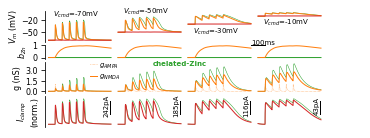

In [9]:
from datavyz import ge
fig3, AX = ge.figure(axes_extents=[[[4,2]],
                                   [[4,1]],
                                   [[4,2]],
                                   [[4,2]]],
                     figsize=(.91,.3), hspace=0.4, right=0.01)

Tspace = 100
DT = tstop-t0
for i, Vcmd, output, output0 in zip(range(len(CMD)), CMD, OUTPUTS_CTRL, OUTPUTS_CHELATED):
    
    cond = output['t']>50
    AX[0].plot(output['t'][cond]+i*(DT+Tspace), output0['Vm_syn'][cond], color=ge.green, lw=0.5)
    AX[0].plot(output['t'][cond]+i*(DT+Tspace), output['Vm_syn'][cond], color=ge.orange, lw=1)
    AX[0].plot(output['t'][cond]+i*(DT+Tspace), output['Vm_soma'][cond], color=ge.red, lw=1)
    AX[1].plot(output['t'][cond]+i*(DT+Tspace), output0['bZn_syn'][cond], color=ge.green, lw=1)
    AX[1].plot(output['t'][cond]+i*(DT+Tspace), output['bZn_syn'][cond], color=ge.orange, lw=1)
    AX[2].plot(output['t'][cond]+i*(DT+Tspace), output0['gNMDA_syn'][cond], color=ge.green, lw=0.5)
    if i==0:
        AX[2].plot(output['t'][cond]+i*(DT+Tspace), output['gAMPA_syn'][cond], ':', color=ge.orange, lw=.5, label='$g_{AMPA}$')
        # AX[2].plot(output['t'][cond]+i*(DT+Tspace), output0['gNMDA_syn'][cond], color=ge.green, lw=0.5, label='$g_{NMDA}$, $\Delta_x^0$=0')
        AX[2].plot(output['t'][cond]+i*(DT+Tspace), output['gNMDA_syn'][cond], color=ge.orange, label='$g_{NMDA}$', lw=1)
    else:
        AX[2].plot(output['t'][cond]+i*(DT+Tspace), output['gAMPA_syn'][cond], ':', color=ge.orange, lw=.5)
        AX[2].plot(output['t'][cond]+i*(DT+Tspace), output['gNMDA_syn'][cond], color=ge.orange, lw=1)
    # AX[3].plot(output['t'][cond]+i*(DT+Tspace), 1e3*(output0['Ic'][cond]-output0['Ic'][cond][0]), color=ge.green)
    norm = (np.max(output0['Ic'][cond])-np.min(output0['Ic'][cond]))
    dI2 = 1/norm*(output0['Ic'][cond]-np.min(output0['Ic'][cond]))
    AX[3].plot(output['t'][cond]+i*(DT+Tspace), dI2, color=ge.green, lw=0.5)
    dI = 1/norm*(output['Ic'][cond]-np.min(output['Ic'][cond]))
    AX[3].plot(output['t'][cond]+i*(DT+Tspace), dI, color=ge.red, lw=1)
    AX[3].plot(np.ones(2)*(output['t'][-1]+i*(DT+Tspace)-Tspace/10), (.4, .9), 'k-', lw=1)    
    ge.annotate(AX[3], '%ipA' % (1e3*.5*norm), (output['t'][-1]+i*(DT+Tspace)-Tspace/10,.73), xycoords='data',
                rotation=90, ha='right', size='small', va='center')

ge.legend(AX[2], loc=(.125,.28), size='small', labelspacing=0.3)
# ge.annotate(AX[2], '$g_{NMDA}$\n  $\Delta_x^0$=0', (.57,.3), color=ge.green, size='small')
for i, Vcmd, y in zip(range(len(CMD)), CMD, [-19,-13,-60,-40]):
    ge.annotate(AX[0], '$V_{cmd}$=%imV' % Vcmd, (i*(DT+Tspace)+(DT+Tspace)/2., y), xycoords='data', ha='center', size='small')

ge.annotate(AX[1], '100ms', (1500,1.01), xycoords='data', size='small')
ge.annotate(AX[2], 'chelated-Zinc', (800,3.5), xycoords='data', size='small', color=ge.green, bold=True)
AX[1].plot(1500+np.arange(2)*100, np.ones(2), 'k-', lw=1)    

ge.set_plot(AX[0], ['left'], ylabel='$V_m$ (mV)', yticks=[-50,-20],
            xlim=[output['t'][cond][0],output['t'][-1]+i*600])
ge.set_plot(AX[1], ['left'], ylabel='$a_{Zn}$', yticks=[0,1], ylim=[-0.1, 1.01], ylabelpad=4,
            xlim=[output['t'][cond][0],output['t'][-1]+i*600])
ge.set_plot(AX[2], ['left'], ylabel='g (nS)', ylabelpad=3,
            xlim=[output['t'][cond][0],output['t'][-1]+i*600])
ge.set_plot(AX[3], ['left'], ylabel='$I_{clamp}$\n(norm.)',
            yticks=[], ylim=[-0.1,1.1], ylabelpad=6,
            xlim=[output['t'][cond][0],output['t'][-1]+i*600])

In [10]:
ge.multipanel_figure([[fig1, fig2], [fig3]],
                     LABELS=[['a','b'], ['c']],
                     Y_LABELS = [[0,0],[135]],
                     X=[[0,230], [0], [0]],
                     Y=[[0,-8], [145]],
                     width='one-and-a-half-column',
                     height=100, #grid=True,
                     fig_name='figures/fig-model-description.png')

RUNNING: inkscape figures/fig-model-description.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/fig-model-description.png" --export-dpi=300
[!!] figures/fig-model-description.svg not exported as png
[ok] removed figures/fig-model-description.svg
